In [11]:
def gaussian(shape=(3,3),sigma=0.5):
   
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h  # taken from internet
    
    
def isvalid(a, b, dim):
    if(a<0 or  a>=dim[0]):
        return 0
    if(b<0 or b>=dim[1]):
        return 0
    return 1

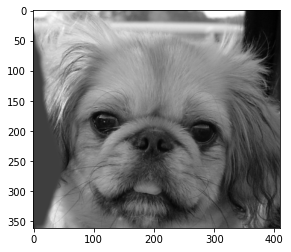

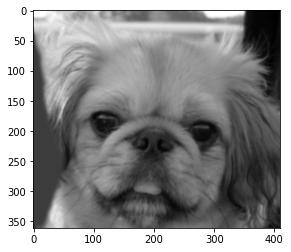

In [1]:
### here starts my own implemntation of the canny edge detection algorithm. 
#Step-1:: 
#Applying a gaussian smoothening to remove noise which does not interfere in the edges. 

import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image as mpimg
from my_imfilter import my_imfilter
from math import *
from skimage.color import rgb2gray
import sys 
sys.setrecursionlimit(10**6)
img= mpimg.imread('../data/dog.bmp')
#img=rgb2gray(img)
R = img[:,:,0]
G = img[:,:,1]
B = img[:,:,2]
img= (0.2989*R) + (0.5870*G) + (0.1140*B) # learnt from internet. 
plt.imshow(img, 'gray')
blur_img=cv.GaussianBlur(img,(5,5),0)
plt.figure()
plt.imshow(blur_img, "gray")


#gauss= gaussian((5,5),2 )
#print(gauss)
#blur_img= cv.filter2D(img, -1, gauss)
#plt.figure()
#plt.imshow(blur_img)


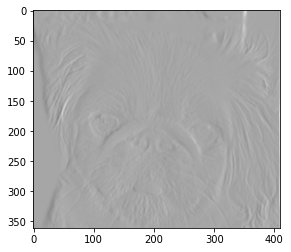

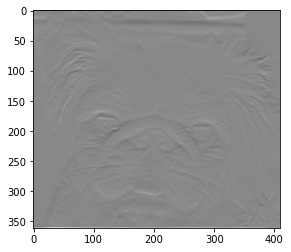

In [13]:
# Now we have gaussian filtered image which is blur_img 
# next step is to have the derivatives with a sobel filter. 

# I am using my my_imfilter function which I wrote in assignment1. 

#We will use soble filter for the use of the calculations of approxiamate discrete gradient. 
soblex= np.array((1, 0, -1 ,2, 0, -2,  1, 0, -1))
soblex= soblex.reshape(3,3)
sobley=np.array((1, 2, 1 ,0, 0, 0,  -1, -2, -1))
sobley=sobley.reshape(3,3)

gradx_img = my_imfilter(blur_img, soblex)
grady_img= my_imfilter(blur_img, sobley)
plt.imshow(gradx_img, "gray")
plt.figure()
plt.imshow(grady_img, "gray")








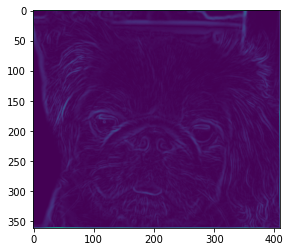

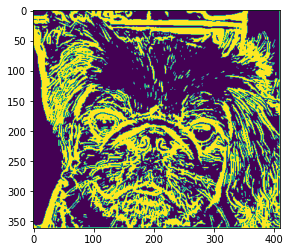

In [14]:
grad_magn= np.sqrt(((gradx_img)*(gradx_img)) + ((grady_img)*(grady_img)))
threshold = 0.1
plt.imshow(grad_magn)
# this holds the magnitude of the gradient vector, sqrt(delx^2 + dely^2)) this is gradient magnitude
# the gradient angle is tan-1 of dely/ delx

# I am not using built in function here because division by zero may create an error here. 
dim = gradx_img.shape
angle_img= np.zeros((dim[0], dim[1]))
edged_img= np.zeros((dim[0], dim[1])) # this will hold our final output with one showing a white pixel and 0 showing a black pixel. 

for i in range(dim[0]):
    for j in range(dim[1]):
        if(gradx_img[i,j]==0):
            angle= 90.
        else:
            angle= degrees(atan(grady_img[i, j] / gradx_img[i,j]))
            if(angle<0):
                angle+=180.
        angle=round(angle, 1)
        

        if (angle >=0 and angle <=22.5 ) or (angle >=157.5 and angle <=180):
            angle=0.
        elif( angle >22.5 and angle <=67.5):
            angle= 45.
        elif(angle >=67.5 and angle <=112.5):
            angle = 90.
        else:
         angle =135.
        angle_img[i,j]= angle
        #print(angle_img[i,j])

        if(grad_magn[i,j] > threshold):
            edged_img[i,j]=1
        # Now I have grad_magnitude and gradient angle matrices. 

       # Now I will set a threshold value only those gradients are permitted with value greater than are considered edges. 

#plt.show(edged_img)
plt.figure()
plt.imshow(edged_img)


In [15]:


# Now three steps are done. 
# Now let's do third step. 
# Non Maximum Supression

# we will check if the pixel has local maxima in gradient direction if yes we will make it 1 else zero


for i in range(dim[0]):
    for j in range(dim[1]):
        a=1
        b=1
        if(angle_img[i,j]==0.):
            grad= grad_magn[i,j]
            if(isvalid(i+1,j,dim) and grad_magn[i+1,j]>grad):
                 a=0
            if(isvalid(i-1,j,dim) and grad_magn[i-1,j]> grad):
                 b=0
        elif(angle_img[i,j]==45.):
            grad= grad_magn[i,j]
            if(isvalid(i+1,j+1,dim) and grad_magn[i+1,j+1]>grad):
                 a=0
            if(isvalid(i-1,j-1,dim) and grad_magn[i-1,j-1]> grad):
                 b=0

        elif(angle_img[i,j]==90):
            grad= grad_magn[i,j]
            if(isvalid(i,j+1,dim) and grad_magn[i,j+1]>grad):
                 a=0
            if(isvalid(i,j-1,dim) and grad_magn[i,j-1]> grad):
                 b=0
        elif(angle_img[i,j]==135):
            grad= grad_magn[i,j]
            if(isvalid(i-1,j+1,dim) and grad_magn[i-1,j+1]>grad):
                 a=0
            if(isvalid(i+1,j-1,dim) and grad_magn[i+1,j-1]> grad):
                 b=0 

        if ( edged_img[i,j]==1 and (a==0 or b==0)):
            edged_img[i,j]=0



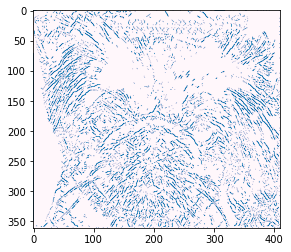

In [16]:
plt.imshow(edged_img, "PuBu")

In [30]:
# Now we will assign each pixel a labe that if it's a strong pixel or a weak pixel and according that will apply our hysteresis for this 
# This step is double thresholding 


lower_threshold=0.1
upper_threshold=0.25

label=np.zeros((dim[0],dim[1]))


for i in range(dim[0]):
    for j in range(dim[1]):
        if( grad_magn[i,j] < lower_threshold):
            label[i,j]=-1
        elif(grad_magn[i,j] > upper_threshold):
            label[i,j] = 1
        else:
             label[i,j] = 0




In [39]:
# for the hysterisis step we use the below code. 
# in computer the core is getting dumped. but this is the correct code. 


dx=[-1, -1, -1,  0, 0,  1, 1, 1]
dy=[-1,  0,  1, -1, 1, -1, 0, 1]
sys.setrecursionlimit(10**7)

def dfs(i, j):
    visited[i,j]=1
    edged_img[i,j]=1
    for k in range(8):
        x=i+dx[k]
        y=j+dy[k]
        
        if(isvalid(x,y,dim) and visited[x,y]==0 ):
            if(label[x,y]==0 or label[x,y]==1):
                dfs(x,y)
            else:
                edged_img[i,j]=0


visited=np.zeros(dim)

for i in range(dim[0]):
    for j in range(dim[1]):
        if(visited[i,j]==0 and label[i,j]==1):
            dfs(i,j)

plt.imshow(edged_img)


 


In [1]:
plt.imshow(edged_img)


NameError: name 'plt' is not defined

2
